Downloading...
From (original): https://drive.google.com/uc?id=1pe4_HgXb9dctFGJXVNlyNcKSXZeht0lX
From (redirected): https://drive.google.com/uc?id=1pe4_HgXb9dctFGJXVNlyNcKSXZeht0lX&confirm=t&uuid=0ff496bd-da01-4c2e-be0a-39710ec5c649
To: /content/train_dataset.zip
100%|██████████| 2.51G/2.51G [00:34<00:00, 72.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1hwz6X-Zp7JpJL35K6P3z7k6O_PTXhUcT
From (redirected): https://drive.google.com/uc?id=1hwz6X-Zp7JpJL35K6P3z7k6O_PTXhUcT&confirm=t&uuid=c22d252d-6595-4952-a6b2-4d435bde9f0f
To: /content/test_dataset.zip
100%|██████████| 1.27G/1.27G [00:06<00:00, 196MB/s]


Removing night (1525).jpg with brightness 20.13
Removing night (1507).jpg with brightness 22.40
Removing night (2657).jpg with brightness 23.22
Removing day_15420.jpg with brightness 209.94
Removing night (1501).jpg with brightness 6.40
Removing night (4074).jpg with brightness 23.85
Removing night (755).jpg with brightness 26.79
Removing night (2054).jpg with brightness 14.86
Removing night (4095).jpg with brightness 27.87
Removing day_03765.jpg with brightness 229.55
Removing night (2117).jpg with brightness 17.54
Removing night (3710).jpg with brightness 20.14
Removing day_03326.jpg with brightness 200.19
Removing night (3069).jpg with brightness 15.42
Removing day_03868.jpg with brightness 204.97
Removing night (2087).jpg with brightness 6.09
Removing night (1025).jpg with brightness 24.04
Removing night (3877).jpg with brightness 24.21
Removing night (3837).jpg with brightness 26.70
Removing night (2057).jpg with brightness 7.94
Removing night (3141).jpg with brightness 28.12
Remo

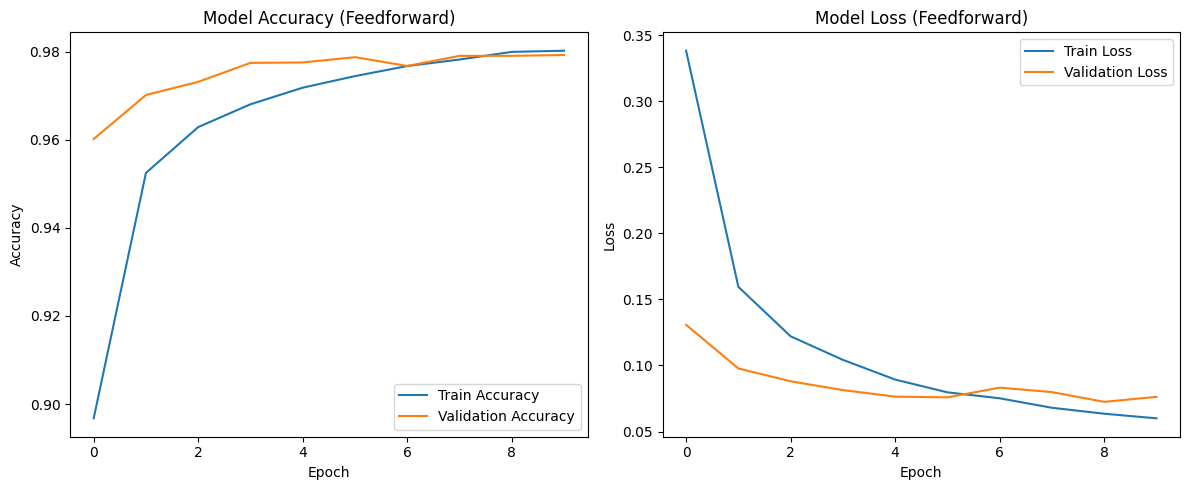

In [8]:
import os
import cv2
import numpy as np
import gdown
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

train_url = 'https://drive.google.com/uc?id=1pe4_HgXb9dctFGJXVNlyNcKSXZeht0lX'
test_url = 'https://drive.google.com/uc?id=1hwz6X-Zp7JpJL35K6P3z7k6O_PTXhUcT'

gdown.download(train_url, 'train_dataset.zip', quiet=False)
gdown.download(test_url, 'test_dataset.zip', quiet=False)

with zipfile.ZipFile('train_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('train_dataset')

with zipfile.ZipFile('test_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('test_dataset')

def filter_night_images(image_folder):
    for root, _, files in os.walk(image_folder):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(root, file)
                img = cv2.imread(image_path)

                if img is None:
                    print(f"Warning: {file} could not be read.")
                    continue

                brightness = np.mean(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

                if brightness < 30 or brightness > 200:
                    print(f"Removing {file} with brightness {brightness:.2f}")
                    os.remove(image_path)

filter_night_images('train_dataset')
filter_night_images('test_dataset')

image_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    'train_dataset',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    'train_dataset',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'test_dataset',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')  # Adjust output layer for the number of classes
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_cnn = ModelCheckpoint('best_cnn_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping_cnn = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_cnn = cnn_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[checkpoint_cnn, early_stopping_cnn]
)

def evaluate_subset(generator, model, n_samples=100):
    total_accuracy = 0
    total_samples = min(len(generator), n_samples)

    for _ in range(total_samples):
        X, y = next(generator)
        y_pred = model.predict(X)
        y_true = np.argmax(y, axis=1)
        y_pred_classes = np.argmax(y_pred, axis=1)

        accuracy = np.sum(y_true == y_pred_classes) / len(y_true)
        total_accuracy += accuracy

    return total_accuracy / total_samples

test_accuracy_cnn = evaluate_subset(test_generator, cnn_model)
print(f'Sampled Test Accuracy (CNN): {test_accuracy_cnn * 100:.2f}%')

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_train = y_train.astype('int')
y_test = y_test.astype('int')

feedforward_model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

feedforward_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_ff = feedforward_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

test_loss_ff, test_accuracy_ff = feedforward_model.evaluate(X_test, y_test)
print(f'Test accuracy (Feedforward Model): {test_accuracy_ff * 100:.2f}%')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_ff.history['accuracy'], label='Train Accuracy')
plt.plot(history_ff.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (Feedforward)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_ff.history['loss'], label='Train Loss')
plt.plot(history_ff.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Feedforward)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()